# Calculate Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmIndeces.ipnyb first

In [2]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.002'

In [3]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod

%run 'utils/compound.ipynb'

In [4]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [5]:
# Here is the data
indecesDa = xarray.load_dataarray('results/cesmTradIndeces.nc')

indecesDa.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '001', '002', '003',
       '004', '005', '006', '007', '008', '009', '010', '011', '012',
       '013'], dtype=object)

# Define a criteria to determine events, and plot an example

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [6]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDa.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaDa = xarray.concat(
    (stdDa.sel(index=['nino34','dmi']), stdDa.sel(index='sam')/2),
    'index'
)

CESM Model Run: LME.002


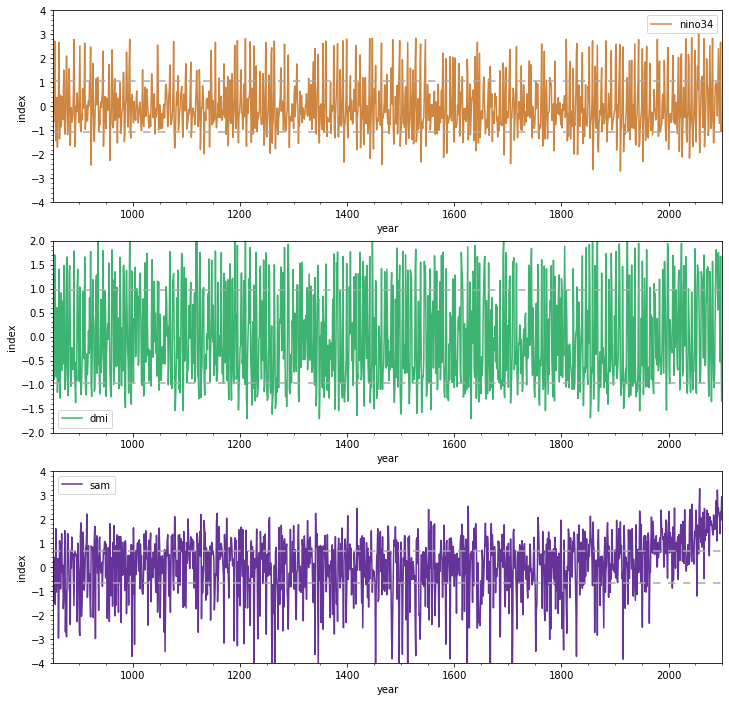

In [7]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'sam']
colors = ['peru', 'mediumseagreen', 'rebeccapurple']
lims = [(-4,4), [-2,2], [-4,4]]

print('CESM Model Run: ' + expToPlot)

# first define somewhere to plot
fig = plt.figure(figsize=(12,12))

for i in range(3):
    
    fig.add_subplot(3,1,i+1)
    
    # plot the actual data
    plotData=indecesDa.sel(experiment=expToPlot, index=indexToPlot[i]) 
    plt.plot(plotData.year, plotData.values, label=indexToPlot[i], color=colors[i])
    
    # draw some horizontal lines for criteria
    eventCrit=criteriaDa.sel(experiment=expToPlot, index=indexToPlot[i]).values
    plt.axhline(y=eventCrit, dashes=(5,5), color='darkgrey')
    plt.axhline(y=-eventCrit, dashes=(5,5), color='darkgrey')

    #Tidy up a bit
    plt.xlabel('year')
    plt.ylabel('index')
    plt.xlim(850,2100)
    plt.ylim(lims[i])
    plt.minorticks_on()
    plt.legend()


# Calculate the compounding years and plot an example

In [8]:
firePos, fireNeg = applyCriteria(indecesDa, criteriaDa)

firePosCount = firePos.sum(dim='index')
fireNegCount = fireNeg.sum(dim='index')

In [9]:
firePos.index.values

array(['nino34', 'dmi', 'sam'], dtype='<U6')

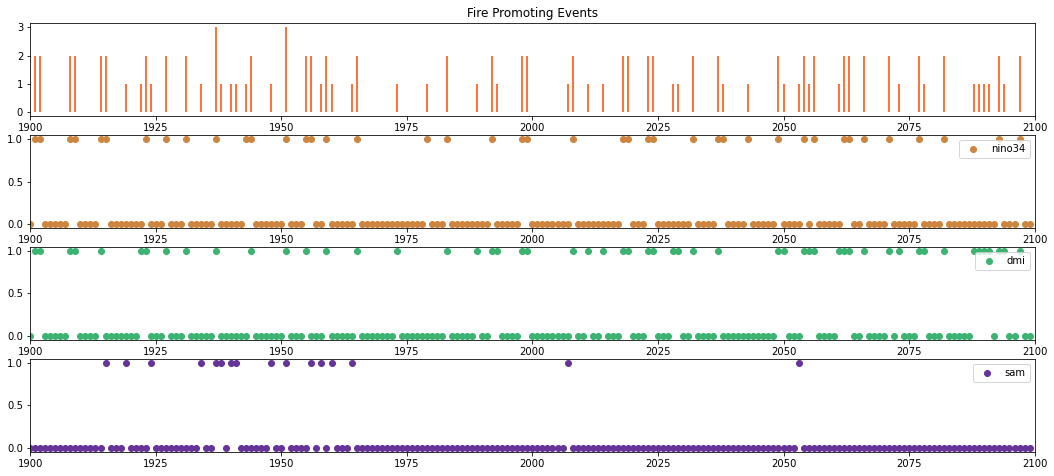

In [20]:
plt.figure(figsize=(18,12))

#plot the pos events in orange 

plt.subplot(6,1,3)

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=firePosCount.sel(experiment=expToPlot),
    colors='orangered', 
    label=expToPlot
)
plt.xlim(1900,2100)

plt.title('Fire Promoting Events')


iPlot=3
for iIndex in firePos.index.values:
    iPlot=iPlot+1
    plt.subplot(6,1,iPlot)
    plt.scatter(
        x=firePos.year, 
        #ymin=0,
        y=(firePos>0).sel(experiment=expToPlot, index=iIndex),
        color=colors[iPlot-4], 
        label=iIndex
    )
    plt.legend()
    plt.xlim(1900,2100)


Text(0.5, 1.0, 'Not Fire Promoting Events')

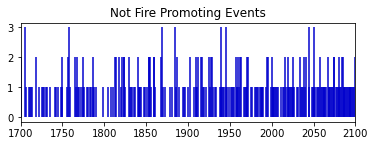

In [11]:
# and the neg count in blue

plt.subplot(2,1,2)

plt.vlines(
    x=fireNeg.year, 
    ymin=0,
    ymax=fireNegCount.sel(experiment=expToPlot),
    colors='mediumblue', 
    label=expToPlot
)
plt.xlim(1700,2100)

plt.title('Not Fire Promoting Events')

# Put the compounds into 30 year intervals

In [12]:
#binsL=(numpy.arange(850,2110,10))

#binsMid=(binsL[:-3]+binsL[3:])/2

#yearBins=numpy.array(list(zip(binsL[:-3], binsL[3:])))

yearBins=numpy.arange(870, 2130, 30)

In [13]:
#binnedPosCount=xarray.concat(
#    [(firePosCount>1).sel(firePosCount.year>(iMid-15), firePosCount.year<(iMid+15)).sum(dim='experiment') for iMid in range(0,len(binsMid))], 
#    dim='year_bins'
#).sum()
binnedPosCount=(firePosCount>1).groupby_bins('year', yearBins).sum() 
binnedNegCount=(fireNegCount>1).groupby_bins('year', yearBins).sum()

In [14]:
#stupidly complicated way to figure out the mid points of my bins?
x = pandas.IntervalIndex(binnedNegCount.year_bins.values).mid

Plot of main ensemble runs over time

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for main ensemble runs.')

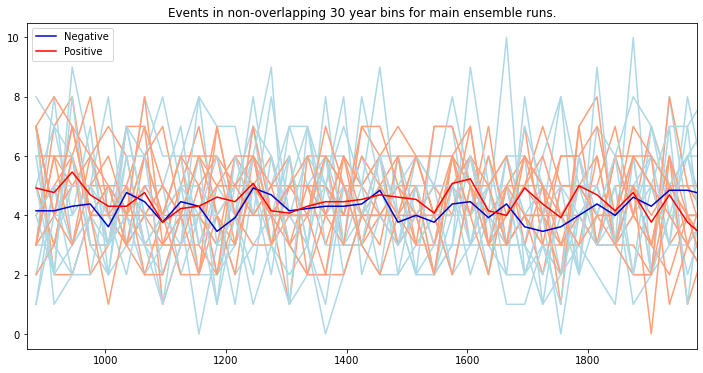

In [15]:
fig = plt.figure(figsize=(12,6))

for iExp in _model.cesmFullForcings:
    plt.plot(x, binnedNegCount.sel(experiment=iExp).values, color='lightblue')
    plt.plot(x, binnedPosCount.sel(experiment=iExp).values, color='lightsalmon')
    
plt.plot(x, binnedNegCount.sel(experiment=_model.cesmFullForcings).mean(dim='experiment') , color='mediumblue', label='Negative')
plt.plot(x, binnedPosCount.sel(experiment=_model.cesmFullForcings).mean(dim='experiment') , color='red', label = 'Positive')   

plt.xlim(870, 1980)
plt.legend()
plt.title('Events in non-overlapping 30 year bins for main ensemble runs.')

Plot of runs with RCP 8.5 forcings

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

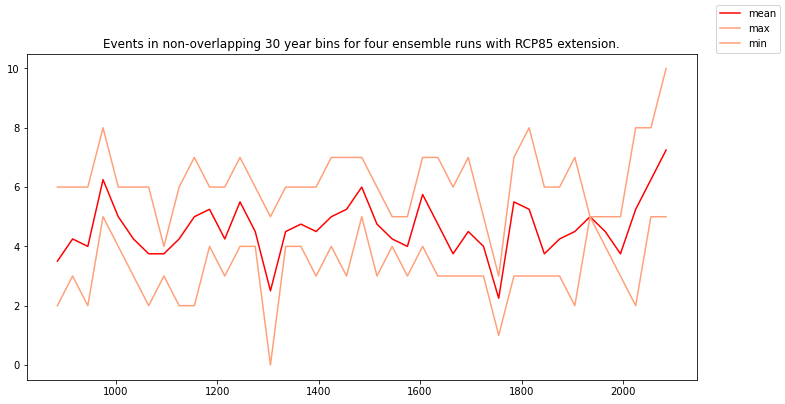

In [16]:
fig = plt.figure(figsize=(12,6))

    
plt.plot(x, binnedPosCount.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='red', label='mean')   
plt.plot(x, binnedPosCount.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightsalmon', label='max')
plt.plot(x, binnedPosCount.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightsalmon', label='min')

fig.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

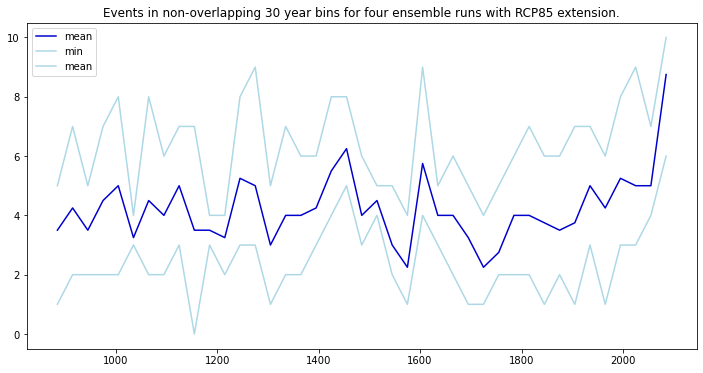

In [17]:
fig = plt.figure(figsize=(12,6))


    
plt.plot(x, binnedNegCount.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='mediumblue', label='mean')
plt.plot(x, binnedNegCount.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightblue', label='min')
plt.plot(x, binnedNegCount.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightblue', label='mean')

plt.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

# Rolling 30 year intervals instead

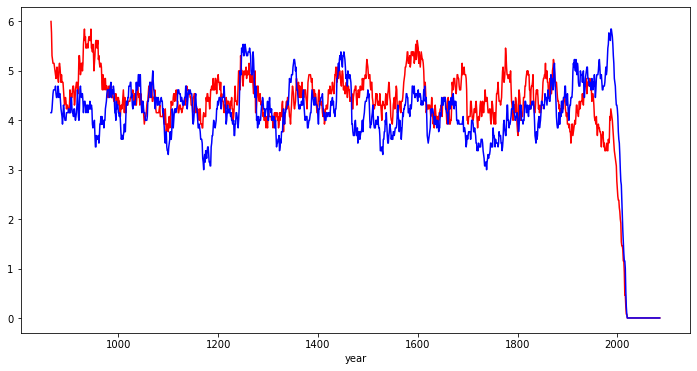

In [18]:
fig = plt.figure(figsize=(12,6))

rollingPCount=(firePosCount.sel(experiment=_model.cesmFullForcings)>1).rolling(year=30, center=True).sum('year').dropna('year')
rollingPCount.mean(dim='experiment').plot(label='mean', color='red')

rollingNCount=(fireNegCount.sel(experiment=_model.cesmFullForcings)>1).rolling(year=30, center=True).sum('year').dropna('year')
rollingNCount.mean(dim='experiment').plot(label='mean', color='blue')


In [19]:
rollingPCount

<xarray.DataArray (experiment: 13, year: 1221)>
array([[7., 6., 5., ..., 0., 0., 0.],
       [4., 4., 5., ..., 0., 0., 0.],
       [5., 5., 4., ..., 0., 0., 0.],
       ...,
       [5., 4., 3., ..., 0., 0., 0.],
       [7., 7., 6., ..., 0., 0., 0.],
       [8., 8., 8., ..., 0., 0., 0.]])
Coordinates:
  * year        (year) int64 865 866 867 868 869 ... 2081 2082 2083 2084 2085
  * experiment  (experiment) object '001' '002' '003' ... '011' '012' '013'